# Phart 1 : Setup and data preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from pathlib import Path

np.random.seed(42)


## Explore Dataset Structure 

In [2]:
ck_plus_path = 'CK+_lands/CK+'

print("Dataset structure:")
print("="*50)

# List all subject folders
subject_folders = sorted([d for d in os.listdir(ck_plus_path) 
                           if os.path.isdir(os.path.join(ck_plus_path, d)) 
                           and d.startswith('S')])

print(f"Found {len(subject_folders)} subjects:  {subject_folders[: 5]}... ")
print()

# Show an example of one subject's structure
example_subject = subject_folders[0]
example_path = os.path.join(ck_plus_path, example_subject)
files_in_subject = os.listdir(example_path)
print(f"Example - {example_subject} contains: ")
for f in files_in_subject[: 5]:
    print(f"  - {f}")

Dataset structure:
Found 123 subjects:  ['S005', 'S010', 'S011', 'S014', 'S022']... 

Example - S005 contains: 
  - omlands.csv


## Load Emotion Mapping

Load the emotion. csv file to understand the labels.

In [3]:
emotion_file = 'CK+_lands/CK+/emotion.csv'

emotions_df = pd.read_csv(emotion_file, sep=';', header=0) 
emotions_df.columns = ['Subject', 'Session', 'Emotion']

print("Emotion mapping file: ")
print(f"\nTotal records: {len(emotions_df)}")
print(f"\nEmotion distribution:")
print(emotions_df['Emotion'].value_counts().sort_index())

emotion_names = {
    1: 'Happy',
    2: 'Fear',
    3: 'Surprise',
    4: 'Anger',
    5: 'Disgust',
    6: 'Sadness'
}

print("\nEmotion names:")
for code, name in emotion_names.items():
    count = (emotions_df['Emotion'] == code).sum()
    print(f"  {code}: {name} ({count})")

Emotion mapping file: 

Total records: 357

Emotion distribution:
Emotion
1    94
2    53
3    77
4    36
5    38
6    59
Name: count, dtype: int64

Emotion names:
  1: Happy (94)
  2: Fear (53)
  3: Surprise (77)
  4: Anger (36)
  5: Disgust (38)
  6: Sadness (59)


In [4]:
emotions_df.head(10)

,Subject,Session,Emotion
0,S005,1,5
1,S010,1,2
2,S010,2,3
3,S010,3,6
4,S010,4,4
5,S010,5,5
6,S010,6,1
7,S011,1,3
8,S011,2,6
9,S011,3,2


## Load Facial Points 

Load the omlands.csv files for each subject and combine them.

In [25]:
inconsistent_column_counts = [] #list to track subjects if there are missing points in the subject's session data

def load_facialPoints_for_subject(subject_id, base_path='CK+_lands/CK+'):
    """
    Loads 68 facial landmarks from a CSV file, handling trailing delimiters.
    """
    file_path = Path(base_path) / subject_id / 'omlands.csv'
    
    if not file_path.exists():
        print(f"Warning: {file_path} not found")
        return None
    
    df = pd.read_csv(file_path, sep=';', header=None)
    
    # Adjust the shape of the dataframe by deleting the empty element after the last semicolon
    if df.shape[1] == 138:
        df = df.iloc[:, :-1]
        
    # If the subject's facial point number is incorrect, add to inconsistent_column_counts list
    if df.shape[1] != 137:
        inconsistent_column_counts.append({
            'subject': subject_id, 'found': df.shape[1], 'expected': 137
        })
        print(f'subjects with inconsistent columns : {len(inconsistent_column_counts)}')
        return None

    # Name columns: [x1, y1, x2, y2...] 
    coords = [f'{axis}{i}' for i in range(1, 69) for axis in ['x', 'y']]
    df.columns = ['Session'] + coords
    
    df['Subject'] = subject_id
    
    return df

# Test with one subject 
test_subject = subject_folders[0]
test_facialPoints = load_facialPoints_for_subject(test_subject)

print(f"Sample data from {test_subject}:")
print(test_facialPoints.head())
print(f"\nShape: {test_facialPoints.shape}")
print(f"Columns: {test_facialPoints.columns.tolist()[:10]}...")  # Show first 10 columns

Sample data from S005:
   Session   x1   y1   x2   y2   x3   y3   x4   y4   x5  ...  y64  x65  y65  \
0        1  430  400  429  478  439  555  457  631  486  ...  669  829  676   
1        1  430  400  429  478  439  555  457  631  486  ...  669  829  676   
2        1  428  398  426  478  435  557  452  635  481  ...  668  829  675   
3        1  431  400  430  477  439  555  456  631  484  ...  667  829  675   
4        1  429  399  430  477  441  555  459  631  488  ...  665  828  672   

   x66  y66  x67  y67  x68  y68  Subject  
0  776  672  746  676  717  672     S005  
1  776  672  746  676  717  672     S005  
2  778  672  746  676  717  673     S005  
3  778  670  747  675  718  671     S005  
4  777  669  746  674  717  669     S005  

[5 rows x 138 columns]

Shape: (12, 138)
Columns: ['Session', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'x5']...


## Build and normalize 

Combine all subjects and normalize the data.

In [28]:
# Load facial points for all subjects
all_facialPoints = []
failed_subjects = []

for subject_id in subject_folders:
    facialPoints = load_facialPoints_for_subject(subject_id)
    if facialPoints is not None:
        all_facialPoints.append(facialPoints)
    else:
        failed_subjects.append(subject_id)

# Combine all into one DataFrame
facialPoints_df = pd.concat(all_facialPoints, ignore_index=True)
print(f"Total samples: {len(facialPoints_df)}")
print(f"Total features: {facialPoints_df.shape[1]}")

# Remove trailing spaces from column names
facialPoints_df.columns = facialPoints_df.columns.str.strip()

Total samples: 10810
Total features: 138


In [92]:
def geometric_normalization(data_df, verbose=False):
    """
    Geometric Normalization 
    
    1. Center all facial points on the nose bridge (point 31)
    2. Scale by inter-eye distance (points 37 and 46)
    """
    
    result_df = data_df.copy()
    
    # Define Reference Points
    NOSE_POINT = 31
    LEFT_EYE = 37
    RIGHT_EYE = 46
    
    nose_x, nose_y = f'x{NOSE_POINT}', f'y{NOSE_POINT}'
    left_eye_x, left_eye_y = f'x{LEFT_EYE}', f'y{LEFT_EYE}'
    right_eye_x, right_eye_y = f'x{RIGHT_EYE}', f'y{RIGHT_EYE}'
    
    # Calculate inter-eye distance 
    # This remains a Series where each row has its own scaling factor
    eye_distance = np.sqrt(
        (result_df[left_eye_x] - result_df[right_eye_x])**2 +
        (result_df[left_eye_y] - result_df[right_eye_y])**2
    )
    
    # Add epsilon to avoid division by zero
    eye_distance = eye_distance + 1e-8

    # Identify all coordinate columns (1 to 68)
    x_cols = [f'x{i}' for i in range(1, 69)]
    y_cols = [f'y{i}' for i in range(1, 69)]

    # 4. Apply transformation
    result_df[x_cols] = result_df[x_cols].sub(result_df[nose_x], axis=0).div(eye_distance, axis=0) #subtract the nose coordinate from every x/y column in that row
    result_df[y_cols] = result_df[y_cols].sub(result_df[nose_y], axis=0).div(eye_distance, axis=0) #scale the result by the eye distance for that row
    
    if verbose:
        print(f"  Geometric normalization complete.")
        print(f"  Nose point ({nose_x}, {nose_y}) is now at (0, 0) for all samples.")
        print(f"  Faces scaled relative to inter-eye distance.")
    
    return result_df

In [93]:
facialPoints_geometric = geometric_normalization(facialPoints_df, verbose=True)

  Geometric normalization complete.
  Nose point (x31, y31) is now at (0, 0) for all samples.
  Faces scaled relative to inter-eye distance.


In [94]:
facialPoints_geometric.head()

,Session,x1,y1,x2,y2,x3,y3,x4,y4,x5,...,y65,x66,y66,x67,y67,x68,y68,Subject,Subject_Clean,Session_Clean
0,1,-0.873623,-0.401097,-0.876370,-0.186812,-0.848898,0.024725,-0.799448,0.233516,-0.719778,...,0.357142,0.076923,0.346153,-0.005494,0.357142,-0.085165,0.346153,S005,S005,001
1,1,-0.873623,-0.401097,-0.876370,-0.186812,-0.848898,0.024725,-0.799448,0.233516,-0.719778,...,0.357142,0.076923,0.346153,-0.005494,0.357142,-0.085165,0.346153,S005,S005,001
2,1,-0.879452,-0.402740,-0.884932,-0.183562,-0.860274,0.032877,-0.813699,0.246575,-0.734247,...,0.356164,0.079452,0.347945,-0.008219,0.358904,-0.087671,0.350685,S005,S005,001
3,1,-0.869562,-0.391303,-0.872279,-0.182065,-0.847823,0.029891,-0.801627,0.236412,-0.725541,...,0.355977,0.073369,0.342390,-0.010870,0.355977,-0.089674,0.345107,S005,S005,001
4,1,-0.867209,-0.387534,-0.864499,-0.176152,-0.834688,0.035230,-0.785908,0.241192,-0.707317,...,0.352304,0.075881,0.344173,-0.008130,0.357724,-0.086721,0.344173,S005,S005,001


**Analysis:** I chose to implement geometric normalization because the faces in the dataset vary in size and position within the image frame. By centering all coordinates on a stable point (like the nose) and scaling them based on a fixed anatomical distance (like the width between the eyes), I remove spatial bias. In other words, this ensures that the classifier learns the actual geometry of the facial features rather than being confused by how close a subject is to the camera or where they are standing in the shot.

In [95]:
def neutral_baseline_normalization(data_df, subject_col='Subject_Clean', session_col='Session_Clean', verbose=False):
    """
    Neutral Baseline Normalization
    
    For each session of each subject:   
    - Identify the first image (neutral baseline)
    - REPLACE all coordinates with differences from neutral baseline
    """
    
    result_df = data_df.copy()
    
    # Get all x and y coordinates
    facial_cols = sorted([col for col in result_df.columns 
                          if col.startswith('x') or col.startswith('y')])
    
    if verbose:   
        print(f"Processing {len(facial_cols)} facial point coordinates")
        print(f"Grouping by: {subject_col}, {session_col}")
    
    session_count = 0
    
    # Process each subject-session group
    for (subject, session), group_indices in result_df.groupby([subject_col, session_col]).groups.items():
        session_count += 1
        
        # Get the neutral baseline (first image in session at index 0)
        neutral_idx = group_indices[0]
        neutral_row = result_df.loc[neutral_idx]
        
        # For all images in this session, compute difference from neutral
        for idx in group_indices:
            for col in facial_cols:
                # replace coordinate with delta from neutral
                result_df.loc[idx, col] = result_df.loc[idx, col] - neutral_row[col]
    
    if verbose:  
        print(f"n\ Neutral baseline normalization applied to {session_count} sessions")
        print(f"  All coordinates now represent MOTION from neutral expression")
    
    return result_df

In [96]:
facialPoints_motion = neutral_baseline_normalization(
    facialPoints_geometric,
    subject_col='Subject_Clean',
    session_col='Session_Clean',
    verbose=True
)

Processing 136 facial point coordinates
Grouping by: Subject_Clean, Session_Clean
\ Neutral baseline normalization applied to 598 sessions
  All coordinates now represent MOTION from neutral expression


In [83]:
facialPoints_motion.head()

,Session,x1,y1,x2,y2,x3,y3,x4,y4,x5,...,y65,x66,y66,x67,y67,x68,y68,Subject,Subject_Clean,Session_Clean
0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,S005,S005,001
1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,S005,S005,001
2,1,-0.005829,-0.001642,-0.008561,0.003251,-0.011376,0.008152,-0.014251,0.013060,-0.014469,...,-0.000977,0.002529,0.001793,-0.002725,0.001763,-0.002507,0.004532,S005,S005,001
3,1,0.004061,0.009794,0.004091,0.004748,0.001075,0.005166,-0.002180,0.002897,-0.005763,...,-0.001165,-0.003553,-0.003762,-0.005375,-0.001165,-0.004509,-0.001045,S005,S005,001
4,1,0.006414,0.013564,0.011872,0.010661,0.014210,0.010505,0.013540,0.007677,0.012460,...,-0.004838,-0.001042,-0.001979,-0.002636,0.000582,-0.001556,-0.001979,S005,S005,001


**Analysis:** I chose to do neutral baseline normalization after the geometric normalization. This shifts the focus from static anatomy to dynamic movement by using the "neutral" first frame of each session as a baseline. By subtracting the coordinates of the neutral face from each image in the same session, I think I successfully isolate the muscle displacement. 
This eliminates the natural differences in face shapes between people. Instead of the model having to learn what a wide mouth or a wide face looks like, it only has to learn the specific vector that defines a smile, regardless of the person's original facial structure.

By combining these techniques, the data is less dependant on unneccessary factors like face shape or subject position in the frame. 

## Merge with emotions

Merge the normalized samples with their corresponding emotions

In [84]:
# facialpoints_geometric

# Ensure session and subject column has the same format to easily merge
emotions_df['Subject_Clean'] = emotions_df['Subject'].str.strip()
emotions_df['Session_Clean'] = emotions_df['Session'].astype(str).str.zfill(3)

facialPoints_geometric['Subject_Clean'] = facialPoints_geometric['Subject'].str.strip()
facialPoints_geometric['Session_Clean'] = facialPoints_geometric['Session'].astype(str).str.zfill(3)

# Merge on subject and session
data_geometric = facialPoints_geometric. merge(
    emotions_df[['Subject_Clean', 'Session_Clean', 'Emotion']], 
    on=['Subject_Clean', 'Session_Clean'], 
    how='left'
)

print("Merged dataset (Geometric): ")
print(data_geometric.head())
print(f"\nShape: {data_geometric.shape}")

# Check for unmatched records
unmatched = data_geometric['Emotion'].isna().sum()
print(f"\nUnmatched records (no emotion label): {unmatched}")

# Remove unmatched records
data_geometric = data_geometric. dropna(subset=['Emotion'])
data_geometric['Emotion'] = data_geometric['Emotion'].astype(int)

print(f"Final dataset size: {len(data_geometric)}")
print(f"\nEmotion distribution:")
emotion_counts = data_geometric['Emotion']. value_counts().sort_index()
for emotion_code, count in emotion_counts.items():
    emotion_name = emotion_names. get(emotion_code, 'Unknown')
    print(f"  {emotion_code} ({emotion_name}): {count} samples")

Merged dataset (Geometric): 
   Session        x1        y1        x2        y2        x3        y3  \
0        1 -0.873623 -0.401097 -0.876370 -0.186812 -0.848898  0.024725   
1        1 -0.873623 -0.401097 -0.876370 -0.186812 -0.848898  0.024725   
2        1 -0.879452 -0.402740 -0.884932 -0.183562 -0.860274  0.032877   
3        1 -0.869562 -0.391303 -0.872279 -0.182065 -0.847823  0.029891   
4        1 -0.867209 -0.387534 -0.864499 -0.176152 -0.834688  0.035230   

         x4        y4        x5  ...       x66       y66       x67       y67  \
0 -0.799448  0.233516 -0.719778  ...  0.076923  0.346153 -0.005494  0.357142   
1 -0.799448  0.233516 -0.719778  ...  0.076923  0.346153 -0.005494  0.357142   
2 -0.813699  0.246575 -0.734247  ...  0.079452  0.347945 -0.008219  0.358904   
3 -0.801627  0.236412 -0.725541  ...  0.073369  0.342390 -0.010870  0.355977   
4 -0.785908  0.241192 -0.707317  ...  0.075881  0.344173 -0.008130  0.357724   

        x68       y68  Subject  Subject_Clean

In [85]:
# facialPoints_motion

facialPoints_motion['Subject_Clean'] = facialPoints_motion['Subject'].str.strip()
facialPoints_motion['Session_Clean'] = facialPoints_motion['Session'].astype(str).str.zfill(3)

# Merge on subject and session
data_motion = facialPoints_motion.merge(
    emotions_df[['Subject_Clean', 'Session_Clean', 'Emotion']], 
    on=['Subject_Clean', 'Session_Clean'], 
    how='left'
)

print("\n" + "=" * 70)
print("Merged dataset (Motion): ")
print(data_motion.head())
print(f"\nShape: {data_motion.shape}")

# Check for unmatched records
unmatched = data_motion['Emotion'].isna().sum()
print(f"\nUnmatched records (no emotion label): {unmatched}")

# Remove unmatched records
data_motion = data_motion. dropna(subset=['Emotion'])
data_motion['Emotion'] = data_motion['Emotion']. astype(int)

print(f"Final dataset size: {len(data_motion)}")
print(f"\nEmotion distribution:")
emotion_counts = data_motion['Emotion'].value_counts().sort_index()
for emotion_code, count in emotion_counts.items():
    emotion_name = emotion_names.get(emotion_code, 'Unknown')
    print(f"  {emotion_code} ({emotion_name}): {count} samples")


Merged dataset (Motion): 
   Session        x1        y1        x2        y2        x3        y3  \
0        1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1        1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2        1 -0.005829 -0.001642 -0.008561  0.003251 -0.011376  0.008152   
3        1  0.004061  0.009794  0.004091  0.004748  0.001075  0.005166   
4        1  0.006414  0.013564  0.011872  0.010661  0.014210  0.010505   

         x4        y4        x5  ...       x66       y66       x67       y67  \
0  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
1  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
2 -0.014251  0.013060 -0.014469  ...  0.002529  0.001793 -0.002725  0.001763   
3 -0.002180  0.002897 -0.005763  ... -0.003553 -0.003762 -0.005375 -0.001165   
4  0.013540  0.007677  0.012460  ... -0.001042 -0.001979 -0.002636  0.000582   

        x68       y68  Subject  Subject_Clean  

In [86]:
data_motion.head()

,Session,x1,y1,x2,y2,x3,y3,x4,y4,x5,...,x66,y66,x67,y67,x68,y68,Subject,Subject_Clean,Session_Clean,Emotion
0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,S005,S005,001,5
1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,S005,S005,001,5
2,1,-0.005829,-0.001642,-0.008561,0.003251,-0.011376,0.008152,-0.014251,0.013060,-0.014469,...,0.002529,0.001793,-0.002725,0.001763,-0.002507,0.004532,S005,S005,001,5
3,1,0.004061,0.009794,0.004091,0.004748,0.001075,0.005166,-0.002180,0.002897,-0.005763,...,-0.003553,-0.003762,-0.005375,-0.001165,-0.004509,-0.001045,S005,S005,001,5
4,1,0.006414,0.013564,0.011872,0.010661,0.014210,0.010505,0.013540,0.007677,0.012460,...,-0.001042,-0.001979,-0.002636,0.000582,-0.001556,-0.001979,S005,S005,001,5


In [87]:
data_motion.shape

(6606, 141)

## Data Validation and Statistics

Check for missing values and get basic statistics.

In [88]:
# Check for missing values
print("Missing values check: ")
missing_by_col = data_motion.isnull().sum()
missing_cols = missing_by_col[missing_by_col > 0]

if len(missing_cols) > 0:
    print(missing_cols)
else:
    print(" No missing values! ")

# Get facial point columns (exclude metadata or subject_id)
facialPoint_cols = [col for col in data_motion.columns if col. startswith('x') or col.startswith('y')]

print(f"\nFacial Point statistics:")
print(f"  Total facial point coordinates: {len(facialPoint_cols)}")
print(f"  Which represents:  {len(facialPoint_cols) // 2} facial points")

# Display basic stats for Facial Points
facialPoints_stats = data_motion[facialPoint_cols].describe()
print(f"\nSample statistics (first 4 facial points):")
print(facialPoints_stats.iloc[:, :8])  # Show first 8 coordinates

# Unique subjects
print(f"\nDataset composition:")
print(f"  Unique subjects:  {data_motion['Subject_Clean'].nunique()}")
print(f"  Total samples: {len(data_motion)}")
print(f"  Samples per emotion:")
print(data_motion['Emotion'].value_counts().sort_index())

Missing values check: 
 No missing values! 

Facial Point statistics:
  Total facial point coordinates: 136
  Which represents:  68 facial points

Sample statistics (first 4 facial points):
                x1           y1           x2           y2           x3  \
count  6606.000000  6606.000000  6606.000000  6606.000000  6606.000000   
mean     -0.001619    -0.006888    -0.002752    -0.003145    -0.003403   
std       0.019854     0.032934     0.019709     0.035842     0.021664   
min      -0.664680    -0.201378    -0.711174    -0.159917    -0.780915   
25%      -0.008944    -0.022074    -0.010178    -0.020049    -0.011683   
50%       0.000000    -0.004021    -0.000905    -0.003001    -0.001570   
75%       0.006231     0.006968     0.004752     0.009674     0.005012   
max       0.100250     0.208001     0.088442     0.219112     0.093357   

                y3           x4           y4  
count  6606.000000  6606.000000  6606.000000  
mean      0.000338    -0.003210     0.003434  
st

**Analysis** : After merging all the samples (session data) from all the subjects, we find 99 unique subjects. Earlier by iterating the CK+ folder, I found 123 subject folders. This means that 24 subjects didn't have emotion data on the emotions_df (extracted from emotions.csv). Since the main foal to to predict emotion for a sample, I thought it was best to eliminate any sample that doesn't have its' corresponding emotion.

So after the cleanup, we have a total of 6606 samples for 99 subjects. Sample count per emotion varies from 1882 to 777.

## Visualize Facial points

Plot some sample faces to verify data integrity.

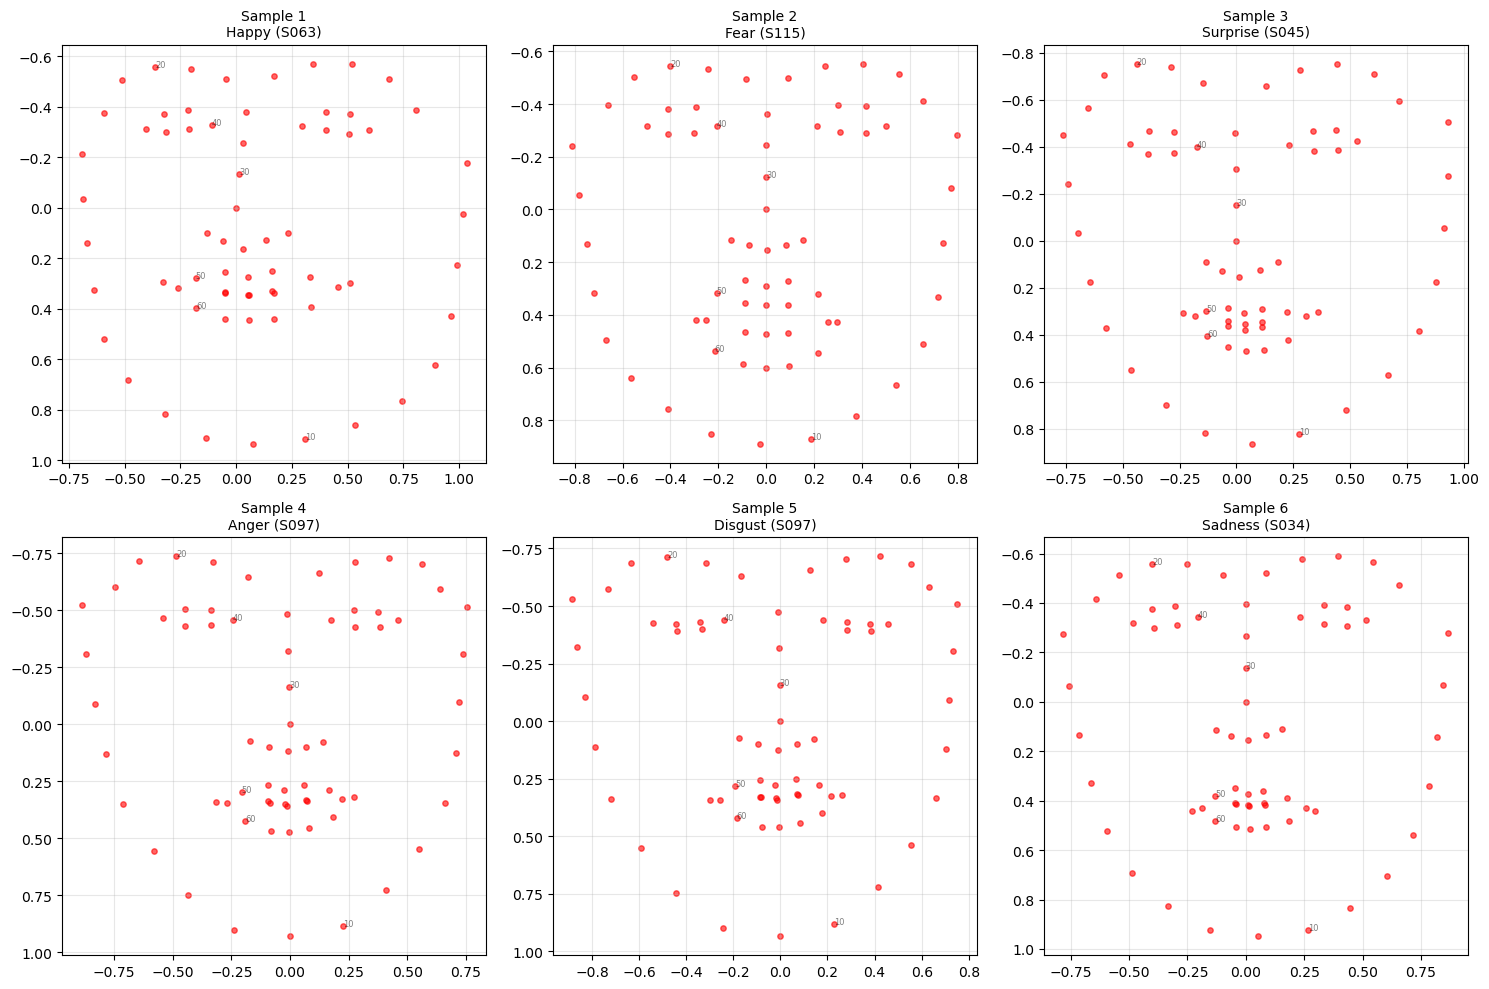

In [89]:
def plot_on_axis(ax, row, emotion_names, title=""):
    """
    Plots facial points onto a specific Matplotlib axis (ax).
    """
    xs = np.array([row[f'x{i}'] for i in range(1, 69)])
    ys = np.array([row[f'y{i}'] for i in range(1, 69)])
    
    # Plot on the provided axis (ax) instead of a new figure
    ax.scatter(xs, ys, c='red', s=15, alpha=0.6)
    
    # Add point numbers
    for i, (x, y) in enumerate(zip(xs, ys), 1):
        if i % 10 == 0: 
            ax.text(x, y, str(i), fontsize=6, alpha=0.5)
    
    emotion_code = int(row['Emotion'])
    emotion_name = emotion_names.get(emotion_code, 'Unknown')
    
    ax.set_title(f"{title}\n{emotion_name} ({row['Subject_Clean']})", fontsize=10)
    ax.invert_yaxis()
    ax.grid(True, alpha=0.3)

# Grid Creation Logic

# Setup the figure and a 3x2 grid of axes
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten() # Flatten 2D array (3,2) to 1D (6,) for easy looping

# Get the unique emotions
unique_emotions = sorted(data_geometric['Emotion'].unique())

for i, emotion_code in enumerate(unique_emotions):
    if i >= 6: break
    
    # Get a random sample for this emotion
    sample = data_geometric[data_geometric['Emotion'] == emotion_code].sample(1).iloc[0]
    
    # Plot on the i-th axis
    plot_on_axis(axes[i], sample, emotion_names, title=f"Sample {i+1}")

plt.tight_layout()
plt.show()

## Save Processed Data 

In [91]:
# Save data
data_motion.to_csv('data_motion.csv', index=False)
print(" Saved:  data_motion.csv")

data_geometric.to_csv('data_geometric.csv', index=False)
print(" Saved:  data_geometric.csv")

# Summary statistics
summary = {
    'total_samples': len(data_motion),
    'total_features': len(facialPoint_cols),
    'num_facialPoints': len(facialPoint_cols) // 2,
    'emotion_names': emotion_names,
    'emotion_distribution': data_motion['Emotion'].value_counts().to_dict(),
    'unique_subjects': data_motion['Subject_Clean'].nunique()
}

print(f"\nDataset Summary:")
for key, value in summary.items():
    if key != 'emotion_names':
        print(f"  {key}:  {value}")

 Saved:  data_motion.csv
 Saved:  data_geometric.csv

Dataset Summary:
  total_samples:  6606
  total_features:  136
  num_facialPoints:  68
  emotion_distribution:  {1: 1882, 3: 1359, 6: 1103, 2: 882, 4: 777, 5: 603}
  unique_subjects:  99
